In [2]:
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.offline as py
import matplotlib as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
# Defining training and test
training_upto = 2020
forecast_upto = (2023-training_upto-1)*12 +3

In [ ]:
# Getting Holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

## Prediction Whole of Barnet

In [31]:
# Read data, get dataframe with crimes/month
monthly_grouped_df = pd.read_csv('C:\\Users\\20203697\\Downloads\\filtered_df_utility_cols.csv')
monthly_grouped_df= monthly_grouped_df.sort_values(['Year','Month num'],ascending=False).groupby(['Year', 'Month num'])['Crime type'].count()
monthly_grouped_df = monthly_grouped_df.to_frame()


# Rename columns, select rows with data and set datetime index
monthly_grouped_df = monthly_grouped_df.rename(columns = {'Month num':'y'})
monthly_grouped_df['day'] = 1
monthly_grouped_df = monthly_grouped_df.reset_index()
monthly_grouped_df = monthly_grouped_df.rename(columns={'Month num': 'month', 'Year': 'year'})
monthly_grouped_df['ds'] = pd.to_datetime(monthly_grouped_df[['year', 'month', 'day']])
monthly_grouped_df['y'] = monthly_grouped_df['Crime type']
monthly_grouped_df['covid']  = 0
monthly_grouped_df['covid'][((monthly_grouped_df['year']==2020) & (monthly_grouped_df['month']>2)) | ((monthly_grouped_df['year']==2021)& (monthly_grouped_df['month']<6))]

# Divide test and train data
train_data = monthly_grouped_df[monthly_grouped_df['year']<(training_upto+1)]
test_data = monthly_grouped_df[(monthly_grouped_df['year']>training_upto)]

,year,month,Crime type,day,ds,y,covid
0,2010,12,372,1,2010-12-01,372,0
1,2011,1,486,1,2011-01-01,486,0
2,2011,2,403,1,2011-02-01,403,0
3,2011,3,408,1,2011-03-01,408,0
4,2011,4,414,1,2011-04-01,414,0
...,...,...,...,...,...,...,...
143,2022,11,246,1,2022-11-01,246,0
144,2022,12,228,1,2022-12-01,228,0
145,2023,1,242,1,2023-01-01,242,0
146,2023,2,199,1,2023-02-01,199,0


### Hyper-parameter tuning

In [32]:
# Defining the parameters & values to be tuned
param_grid = { 
    'seasonality_mode':('multiplicative','additive'), 
    'changepoint_prior_scale': [0.5, 0.1, 1,],
    'seasonality_prior_scale': [0.5, 0.1, 1],
    'holidays_prior_scale':[1, 10, 25, 50],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

cutoffs = pd.date_range(start='2015-01-01', end='2021-12-01', freq='2MS')

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, holidays= holiday).fit(monthly_grouped_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print("Mean absolute error: ", np.argmin(maes))
best_params = all_params[np.argmin(maes)]
print("Best parameters", best_params)

17:12:36 - cmdstanpy - INFO - Chain [1] start processing
17:12:36 - cmdstanpy - INFO - Chain [1] done processing
17:13:05 - cmdstanpy - INFO - Chain [1] start processing
17:13:05 - cmdstanpy - INFO - Chain [1] done processing
17:13:34 - cmdstanpy - INFO - Chain [1] start processing
17:13:34 - cmdstanpy - INFO - Chain [1] done processing
17:14:03 - cmdstanpy - INFO - Chain [1] start processing
17:14:03 - cmdstanpy - INFO - Chain [1] done processing
17:14:33 - cmdstanpy - INFO - Chain [1] start processing
17:14:33 - cmdstanpy - INFO - Chain [1] done processing
17:14:58 - cmdstanpy - INFO - Chain [1] start processing
17:14:58 - cmdstanpy - INFO - Chain [1] done processing
17:15:22 - cmdstanpy - INFO - Chain [1] start processing
17:15:22 - cmdstanpy - INFO - Chain [1] done processing
17:15:46 - cmdstanpy - INFO - Chain [1] start processing
17:15:46 - cmdstanpy - INFO - Chain [1] done processing
17:16:12 - cmdstanpy - INFO - Chain [1] start processing
17:16:12 - cmdstanpy - INFO - Chain [1]

Mean absolute error:  23
Best parameters {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'holidays_prior_scale': 50}


17:40:25 - cmdstanpy - INFO - Chain [1] start processing
17:40:25 - cmdstanpy - INFO - Chain [1] done processing


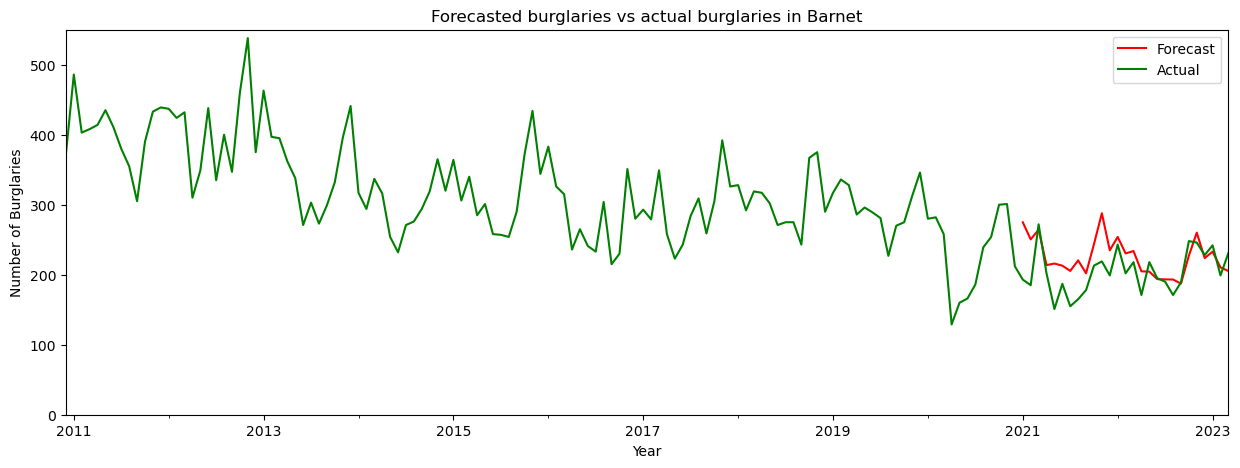

27.395094502580513
-0.39598877558656076


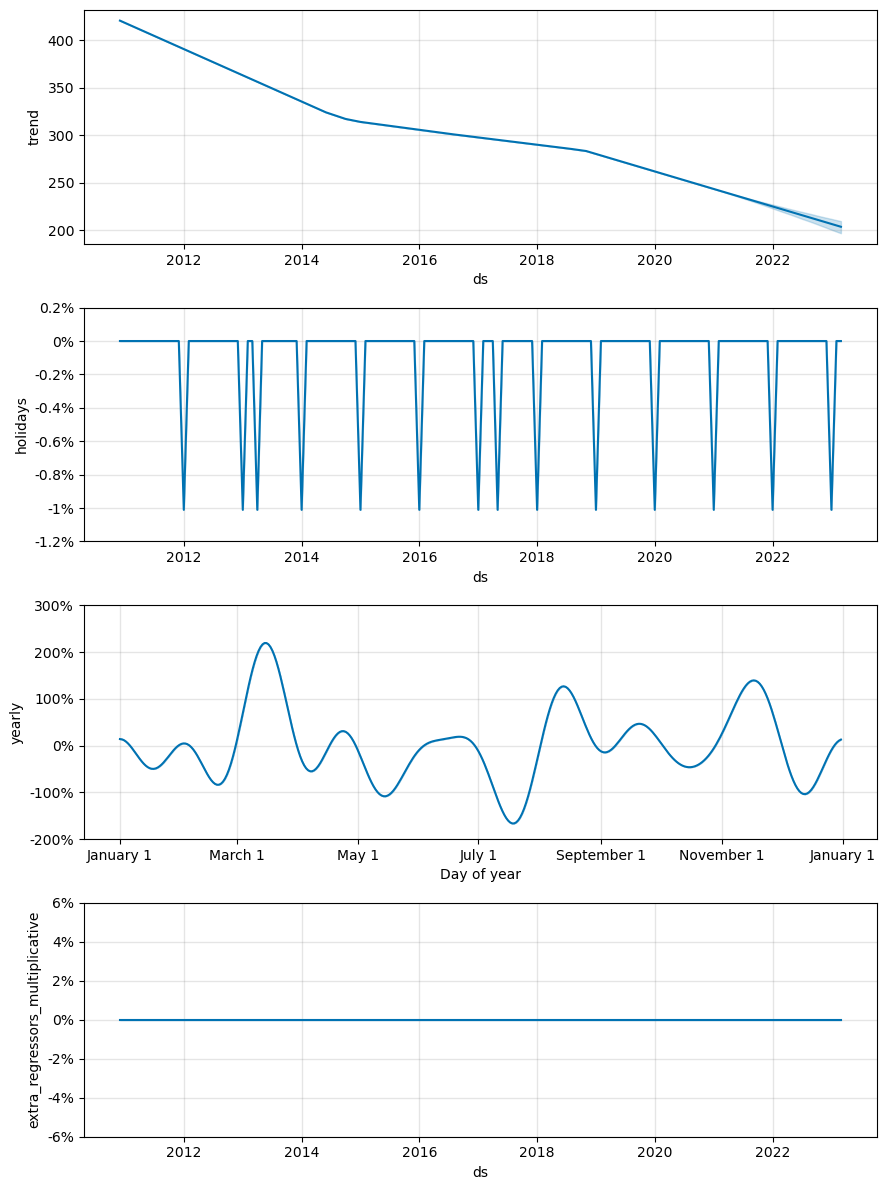

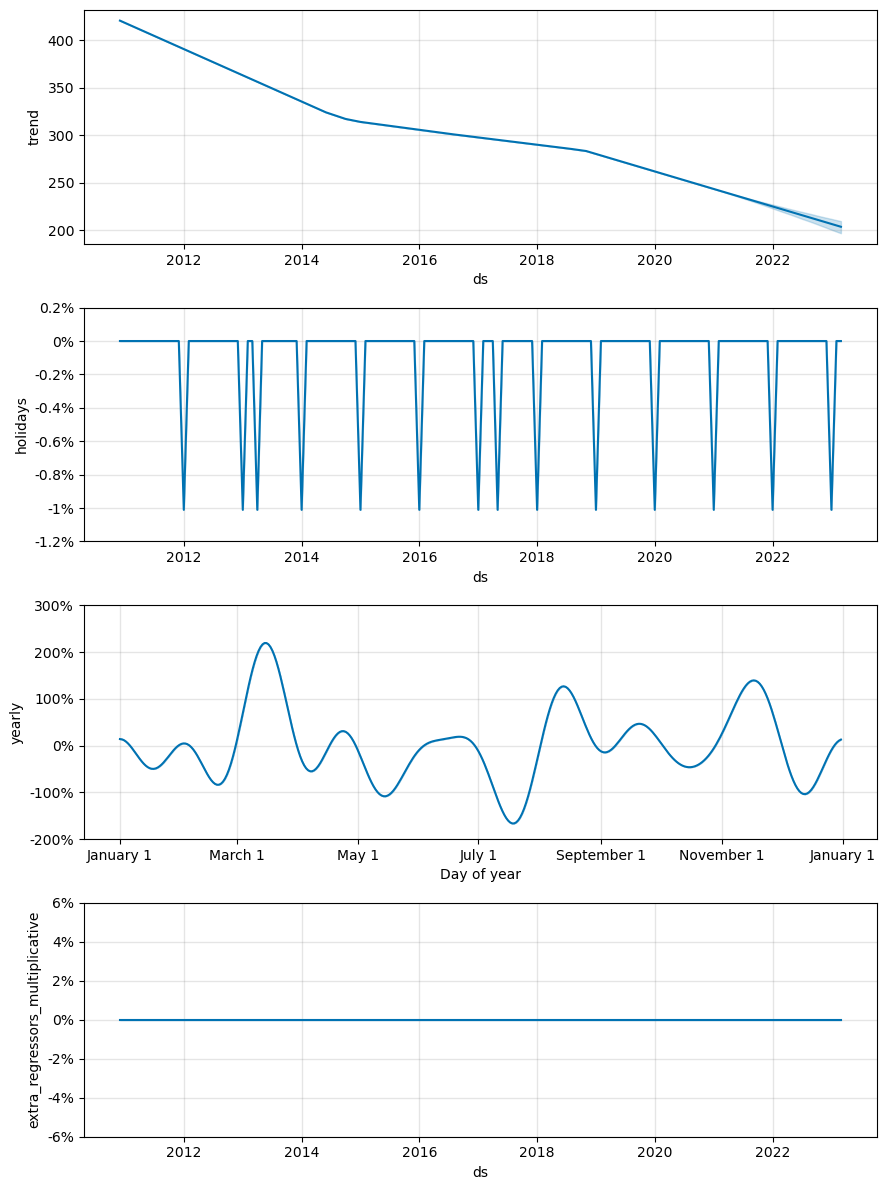

In [35]:
# Train the model with the best parameters and forecast
best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.1, seasonality_prior_scale= 1, holidays_prior_scale= 50, holidays= holiday)
best_model.add_regressor('covid')
best_model.fit(train_data)
future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
future_dates['covid'] = 0
forecast = best_model.predict(future_dates)

# Plot predictions
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
monthly_grouped_df.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
plt.title('Forecasted burglaries vs actual burglaries in Barnet')
plt.xlabel("Year")
plt.ylabel("Number of Burglaries")
plt.ylim(0,550)
plt.show()

print("MAE", mean_absolute_error(test_data['y'], forecast['yhat'][-forecast_upto:]))
print("R2", r2_score(test_data['y'], forecast['yhat'][-forecast_upto:]))

best_model.plot_components(forecast)

## Prediction per ward

In [36]:
# Create the dataframe
file =  pd.read_csv('C:/Users/20203697/Downloads/filtered_df_utility_cols.csv')
df_per_ward= file.sort_values(['Year','Month num'],ascending=False).groupby(['Ward', 'Year', 'Month num']).count()

# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='3/1/2023', freq='MS').to_frame()
df_per_ward = df_per_ward.reset_index()

# Specify columns: ds, y, Date, covid
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward['y'] = df_per_ward['Crime type']
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
df_per_ward['covid']  = 0
df_per_ward['covid'][((df_per_ward['year']==2020) & (df_per_ward['month']>2)) | ((df_per_ward['year']==2021)& (df_per_ward['month']<6))]
dates['Date'] = dates[0]
dates = dates[['Date']]

['Barnet Vale' 'Brunswick Park' 'Burnt Oak' 'Childs Hill'
 'Colindale North' 'Colindale South' 'Cricklewood' 'East Barnet'
 'East Finchley' 'Edgware' 'Edgwarebury' 'Finchley Church End'
 'Friern Barnet' 'Garden Suburb' 'Golders Green' 'Hendon' 'High Barnet'
 'Mill Hill' 'Nan' 'Totteridge and Woodside' 'Underhill' 'West Finchley'
 'West Hendon' 'Whetstone' 'Woodhouse']


C:\Users\20203697\AppData\Local\Temp\ipykernel_14740\937257679.py:36: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



          Date         ds  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  11                                0      0
1   2011-01-01 2011-01-01  2011  14                               14      0
2   2011-02-01 2011-02-01  2011  21                               21      0
3   2011-03-01 2011-03-01  2011  12                               12      0
4   2011-04-01 2011-04-01  2011  14                               14      0
..         ...        ...   ...  ..                              ...    ...
116 2020-08-01 2020-08-01  2020   8                                8      0
117 2020-09-01 2020-09-01  2020   5                                5      0
118 2020-10-01 2020-10-01  2020  12                               12      0
119 2020-11-01 2020-11-01  2020   8                                8      0
120 2020-12-01 2020-12-01  2020   6                                6      0

[121 rows x 6 columns]


17:55:47 - cmdstanpy - INFO - Chain [1] start processing
17:55:48 - cmdstanpy - INFO - Chain [1] done processing


            ds       Date  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  11                                0      0
1   2011-01-01 2011-01-01  2011  14                               14      0
2   2011-02-01 2011-02-01  2011  21                               21      0
3   2011-03-01 2011-03-01  2011  12                               12      0
4   2011-04-01 2011-04-01  2011  14                               14      0
..         ...        ...   ...  ..                              ...    ...
143 2022-11-01 2022-11-01  2022   4                                4      0
144 2022-12-01 2022-12-01  2022   4                                4      0
145 2023-01-01 2023-01-01  2023   6                                6      0
146 2023-02-01 2023-02-01  2023  14                               14      0
147 2023-03-01 2023-03-01  2023  13                               13      0

[148 rows x 6 columns]
Brunswick Park


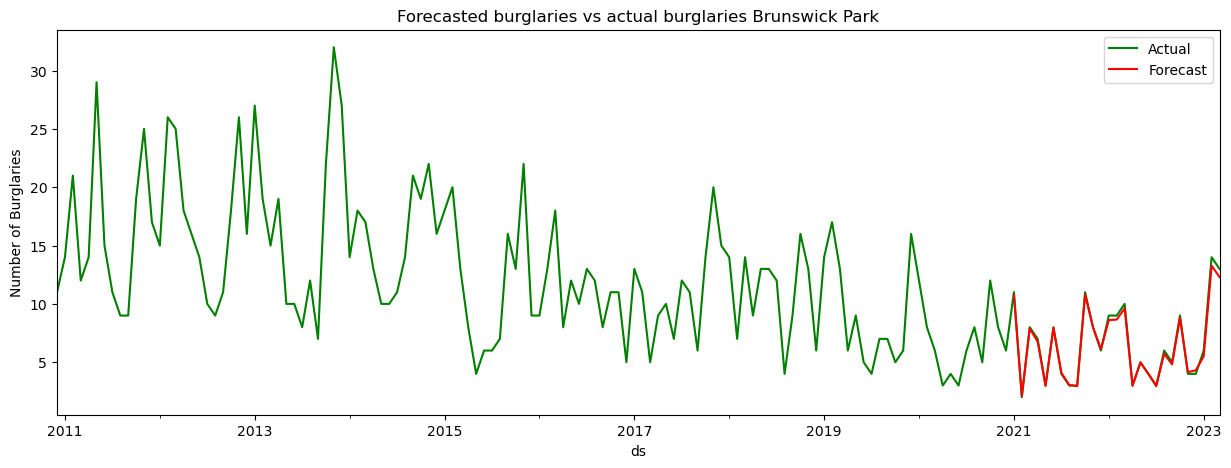

C:\Users\20203697\AppData\Local\Temp\ipykernel_14740\937257679.py:36: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:55:48 - cmdstanpy - INFO - Chain [1] start processing


          Date         ds  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  10                                0      0
1   2011-01-01 2011-01-01  2011  14                               14      0
2   2011-02-01 2011-02-01  2011   9                                9      0
3   2011-03-01 2011-03-01  2011   5                                5      0
4   2011-04-01 2011-04-01  2011  12                               12      0
..         ...        ...   ...  ..                              ...    ...
116 2020-08-01 2020-08-01  2020   8                                8      0
117 2020-09-01 2020-09-01  2020  11                               11      0
118 2020-10-01 2020-10-01  2020   9                                9      0
119 2020-11-01 2020-11-01  2020  15                               15      0
120 2020-12-01 2020-12-01  2020  11                               11      0

[121 rows x 6 columns]


17:55:48 - cmdstanpy - INFO - Chain [1] done processing


            ds       Date  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  10                                0      0
1   2011-01-01 2011-01-01  2011  14                               14      0
2   2011-02-01 2011-02-01  2011   9                                9      0
3   2011-03-01 2011-03-01  2011   5                                5      0
4   2011-04-01 2011-04-01  2011  12                               12      0
..         ...        ...   ...  ..                              ...    ...
143 2022-11-01 2022-11-01  2022  15                               15      0
144 2022-12-01 2022-12-01  2022  14                               14      0
145 2023-01-01 2023-01-01  2023  11                               11      0
146 2023-02-01 2023-02-01  2023   5                                5      0
147 2023-03-01 2023-03-01  2023  11                               11      0

[148 rows x 6 columns]
Burnt Oak


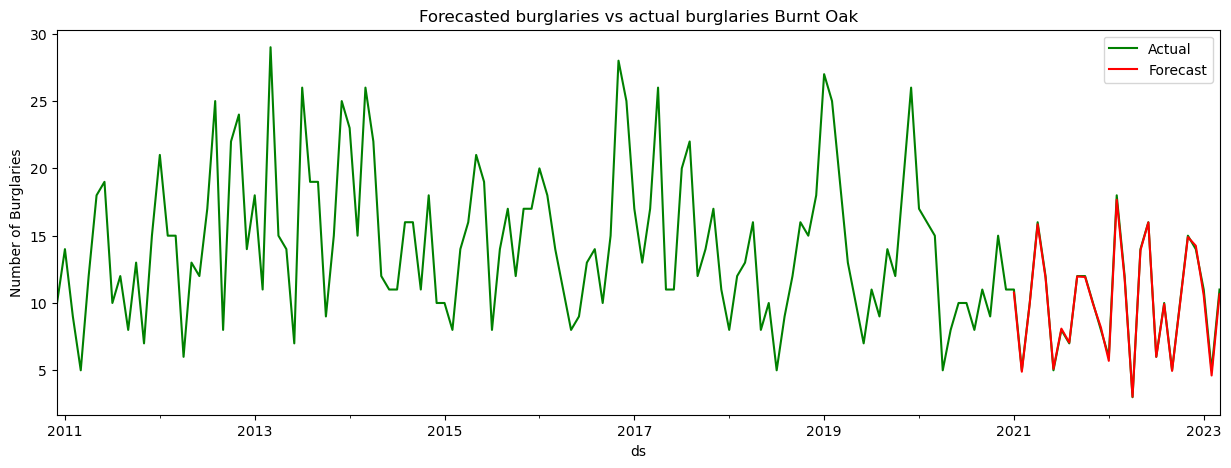

          Date         ds  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  19                                0      0
1   2011-01-01 2011-01-01  2011  39                               39      0
2   2011-02-01 2011-02-01  2011  22                               22      0
3   2011-03-01 2011-03-01  2011  32                               32      0
4   2011-04-01 2011-04-01  2011  31                               31      0
..         ...        ...   ...  ..                              ...    ...
116 2020-08-01 2020-08-01  2020  23                               23      0
117 2020-09-01 2020-09-01  2020  12                               12      0
118 2020-10-01 2020-10-01  2020  18                               18      0
119 2020-11-01 2020-11-01  2020  10                               10      0
120 2020-12-01 2020-12-01  2020  13                               13      0

[121 rows x 6 columns]


C:\Users\20203697\AppData\Local\Temp\ipykernel_14740\937257679.py:36: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:55:49 - cmdstanpy - INFO - Chain [1] start processing
17:55:49 - cmdstanpy - INFO - Chain [1] done processing


            ds       Date  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  19                                0      0
1   2011-01-01 2011-01-01  2011  39                               39      0
2   2011-02-01 2011-02-01  2011  22                               22      0
3   2011-03-01 2011-03-01  2011  32                               32      0
4   2011-04-01 2011-04-01  2011  31                               31      0
..         ...        ...   ...  ..                              ...    ...
143 2022-11-01 2022-11-01  2022  31                               31      0
144 2022-12-01 2022-12-01  2022  21                               21      0
145 2023-01-01 2023-01-01  2023  22                               22      0
146 2023-02-01 2023-02-01  2023  21                               21      0
147 2023-03-01 2023-03-01  2023  19                               19      0

[148 rows x 6 columns]
Childs Hill


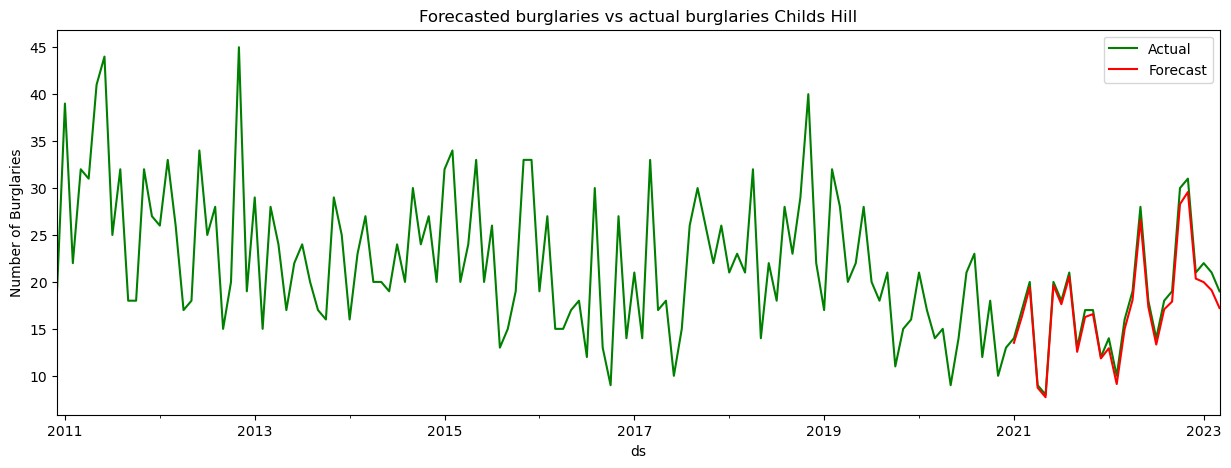

          Date         ds  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  18                                0      0
1   2011-01-01 2011-01-01  2011  21                               21      0
2   2011-02-01 2011-02-01  2011  12                               12      0
3   2011-03-01 2011-03-01  2011  14                               14      0
4   2011-04-01 2011-04-01  2011  16                               16      0
..         ...        ...   ...  ..                              ...    ...
116 2020-08-01 2020-08-01  2020   5                                5      0
117 2020-09-01 2020-09-01  2020   8                                8      0
118 2020-10-01 2020-10-01  2020   9                                9      0
119 2020-11-01 2020-11-01  2020  12                               12      0
120 2020-12-01 2020-12-01  2020   3                                3      0

[121 rows x 6 columns]


C:\Users\20203697\AppData\Local\Temp\ipykernel_14740\937257679.py:36: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:55:49 - cmdstanpy - INFO - Chain [1] start processing
17:55:49 - cmdstanpy - INFO - Chain [1] done processing


            ds       Date  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  18                                0      0
1   2011-01-01 2011-01-01  2011  21                               21      0
2   2011-02-01 2011-02-01  2011  12                               12      0
3   2011-03-01 2011-03-01  2011  14                               14      0
4   2011-04-01 2011-04-01  2011  16                               16      0
..         ...        ...   ...  ..                              ...    ...
143 2022-11-01 2022-11-01  2022   5                                5      0
144 2022-12-01 2022-12-01  2022  12                               12      0
145 2023-01-01 2023-01-01  2023   9                                9      0
146 2023-02-01 2023-02-01  2023   5                                5      0
147 2023-03-01 2023-03-01  2023   8                                8      0

[148 rows x 6 columns]
East Barnet


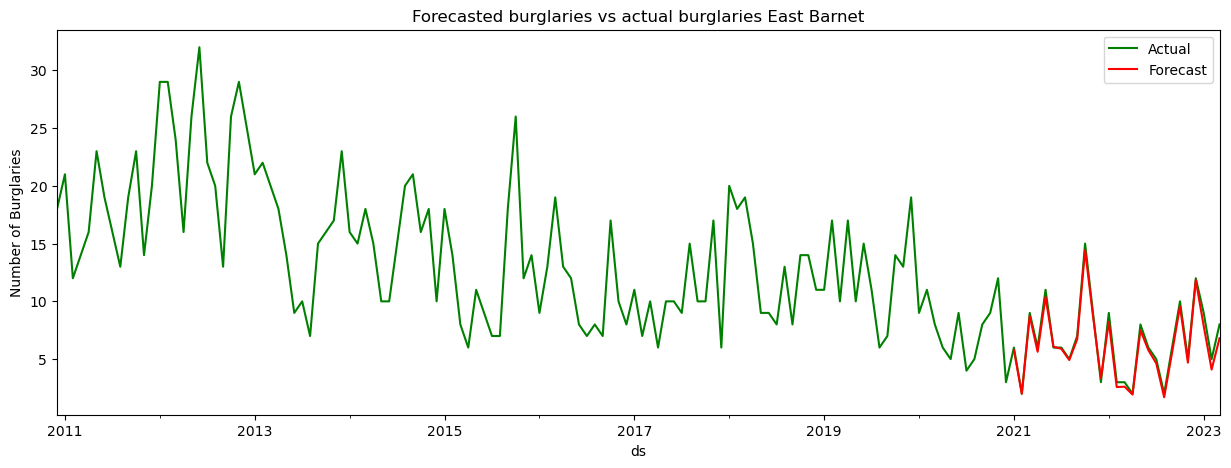

C:\Users\20203697\AppData\Local\Temp\ipykernel_14740\937257679.py:36: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:55:50 - cmdstanpy - INFO - Chain [1] start processing


          Date         ds  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  17                                0      0
1   2011-01-01 2011-01-01  2011  19                               19      0
2   2011-02-01 2011-02-01  2011  13                               13      0
3   2011-03-01 2011-03-01  2011  14                               14      0
4   2011-04-01 2011-04-01  2011   7                                7      0
..         ...        ...   ...  ..                              ...    ...
116 2020-08-01 2020-08-01  2020   5                                5      0
117 2020-09-01 2020-09-01  2020  10                               10      0
118 2020-10-01 2020-10-01  2020  14                               14      0
119 2020-11-01 2020-11-01  2020   8                                8      0
120 2020-12-01 2020-12-01  2020   9                                9      0

[121 rows x 6 columns]


17:55:50 - cmdstanpy - INFO - Chain [1] done processing


            ds       Date  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  17                                0      0
1   2011-01-01 2011-01-01  2011  19                               19      0
2   2011-02-01 2011-02-01  2011  13                               13      0
3   2011-03-01 2011-03-01  2011  14                               14      0
4   2011-04-01 2011-04-01  2011   7                                7      0
..         ...        ...   ...  ..                              ...    ...
143 2022-11-01 2022-11-01  2022   3                                3      0
144 2022-12-01 2022-12-01  2022   6                                6      0
145 2023-01-01 2023-01-01  2023   4                                4      0
146 2023-02-01 2023-02-01  2023   5                                5      0
147 2023-03-01 2023-03-01  2023   9                                9      0

[148 rows x 6 columns]
East Finchley


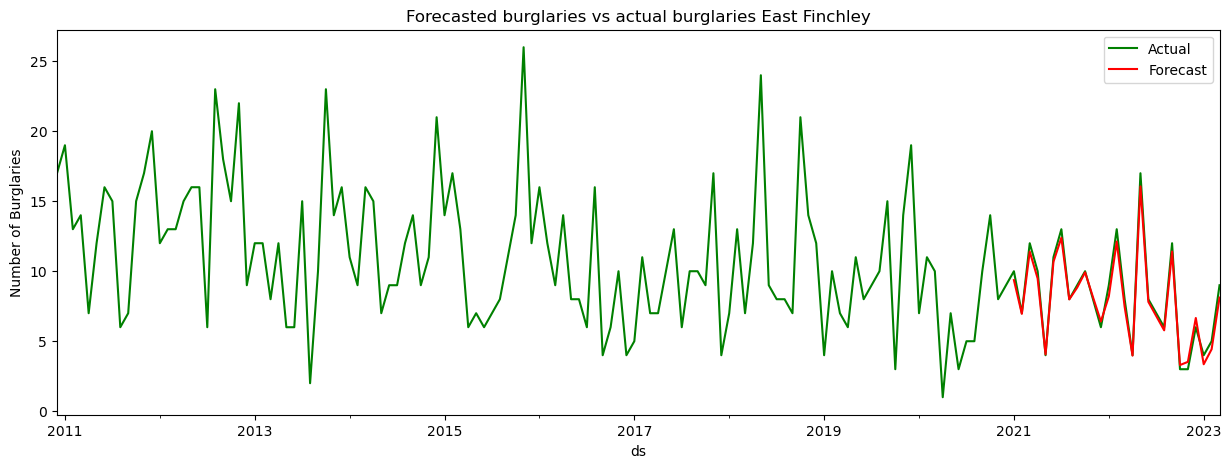

          Date         ds  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  22                                0      0
1   2011-01-01 2011-01-01  2011  13                               13      0
2   2011-02-01 2011-02-01  2011  15                               15      0
3   2011-03-01 2011-03-01  2011   4                                4      0
4   2011-04-01 2011-04-01  2011  12                               12      0
..         ...        ...   ...  ..                              ...    ...
116 2020-08-01 2020-08-01  2020  16                               16      0
117 2020-09-01 2020-09-01  2020  11                               11      0
118 2020-10-01 2020-10-01  2020  18                               18      0
119 2020-11-01 2020-11-01  2020  15                               15      0
120 2020-12-01 2020-12-01  2020  10                               10      0

[121 rows x 6 columns]


C:\Users\20203697\AppData\Local\Temp\ipykernel_14740\937257679.py:36: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:55:51 - cmdstanpy - INFO - Chain [1] start processing
17:55:51 - cmdstanpy - INFO - Chain [1] done processing


            ds       Date  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  22                                0      0
1   2011-01-01 2011-01-01  2011  13                               13      0
2   2011-02-01 2011-02-01  2011  15                               15      0
3   2011-03-01 2011-03-01  2011   4                                4      0
4   2011-04-01 2011-04-01  2011  12                               12      0
..         ...        ...   ...  ..                              ...    ...
143 2022-11-01 2022-11-01  2022   9                                9      0
144 2022-12-01 2022-12-01  2022  11                               11      0
145 2023-01-01 2023-01-01  2023  11                               11      0
146 2023-02-01 2023-02-01  2023  11                               11      0
147 2023-03-01 2023-03-01  2023  11                               11      0

[148 rows x 6 columns]
Edgware


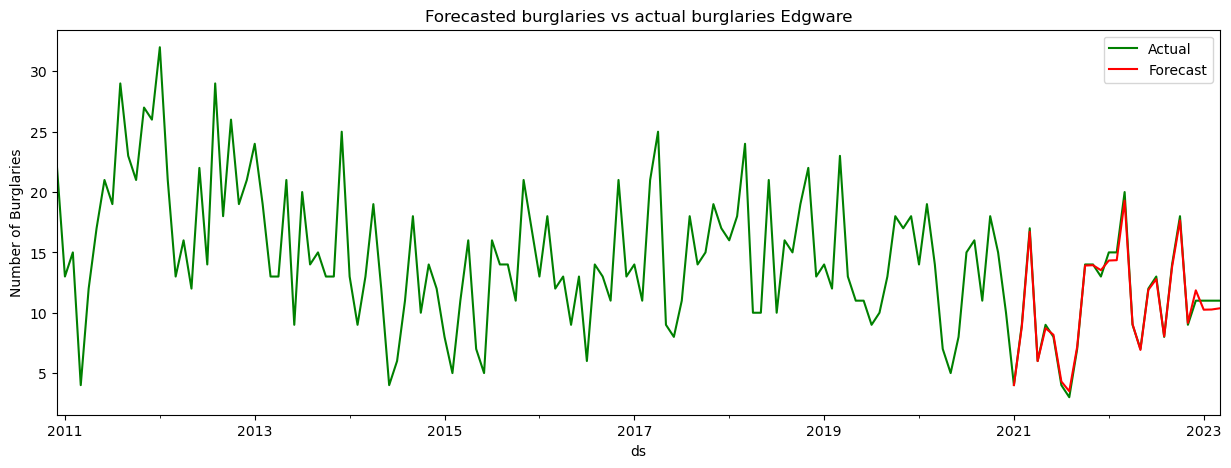

C:\Users\20203697\AppData\Local\Temp\ipykernel_14740\937257679.py:36: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:55:51 - cmdstanpy - INFO - Chain [1] start processing


          Date         ds  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  21                                0      0
1   2011-01-01 2011-01-01  2011  22                               22      0
2   2011-02-01 2011-02-01  2011  26                               26      0
3   2011-03-01 2011-03-01  2011  25                               25      0
4   2011-04-01 2011-04-01  2011  18                               18      0
..         ...        ...   ...  ..                              ...    ...
116 2020-08-01 2020-08-01  2020  18                               18      0
117 2020-09-01 2020-09-01  2020  16                               16      0
118 2020-10-01 2020-10-01  2020  24                               24      0
119 2020-11-01 2020-11-01  2020  14                               14      0
120 2020-12-01 2020-12-01  2020  14                               14      0

[121 rows x 6 columns]


17:55:51 - cmdstanpy - INFO - Chain [1] done processing


            ds       Date  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  21                                0      0
1   2011-01-01 2011-01-01  2011  22                               22      0
2   2011-02-01 2011-02-01  2011  26                               26      0
3   2011-03-01 2011-03-01  2011  25                               25      0
4   2011-04-01 2011-04-01  2011  18                               18      0
..         ...        ...   ...  ..                              ...    ...
143 2022-11-01 2022-11-01  2022   9                                9      0
144 2022-12-01 2022-12-01  2022  16                               16      0
145 2023-01-01 2023-01-01  2023  11                               11      0
146 2023-02-01 2023-02-01  2023  17                               17      0
147 2023-03-01 2023-03-01  2023  18                               18      0

[148 rows x 6 columns]
Finchley Church End


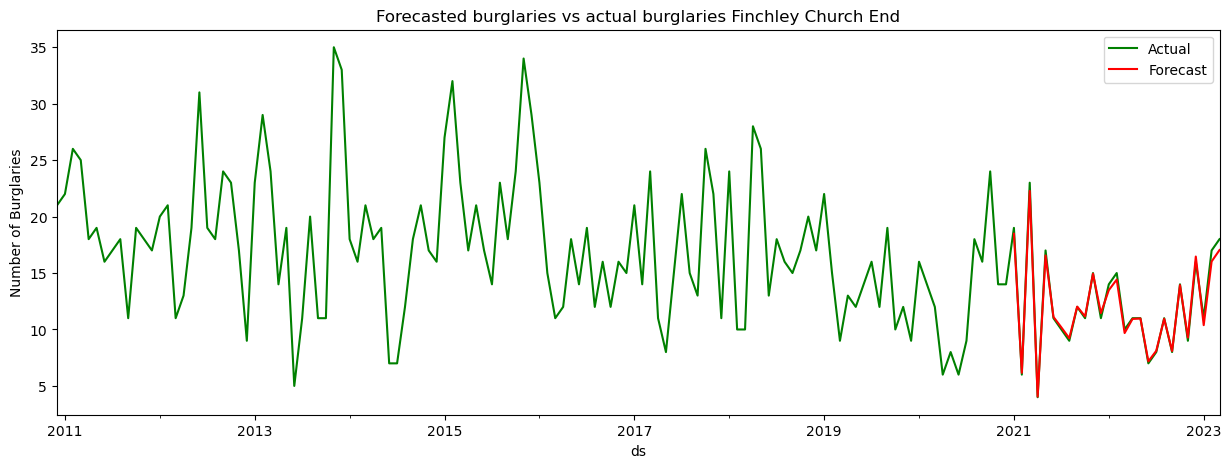

          Date         ds  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  12                                0      0
1   2011-01-01 2011-01-01  2011  32                               32      0
2   2011-02-01 2011-02-01  2011  19                               19      0
3   2011-03-01 2011-03-01  2011  23                               23      0
4   2011-04-01 2011-04-01  2011  19                               19      0
..         ...        ...   ...  ..                              ...    ...
116 2020-08-01 2020-08-01  2020  12                               12      0
117 2020-09-01 2020-09-01  2020  19                               19      0
118 2020-10-01 2020-10-01  2020  21                               21      0
119 2020-11-01 2020-11-01  2020   7                                7      0
120 2020-12-01 2020-12-01  2020  11                               11      0

[121 rows x 6 columns]


C:\Users\20203697\AppData\Local\Temp\ipykernel_14740\937257679.py:36: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:55:52 - cmdstanpy - INFO - Chain [1] start processing
17:55:52 - cmdstanpy - INFO - Chain [1] done processing


            ds       Date  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  12                                0      0
1   2011-01-01 2011-01-01  2011  32                               32      0
2   2011-02-01 2011-02-01  2011  19                               19      0
3   2011-03-01 2011-03-01  2011  23                               23      0
4   2011-04-01 2011-04-01  2011  19                               19      0
..         ...        ...   ...  ..                              ...    ...
143 2022-11-01 2022-11-01  2022  12                               12      0
144 2022-12-01 2022-12-01  2022   8                                8      0
145 2023-01-01 2023-01-01  2023  10                               10      0
146 2023-02-01 2023-02-01  2023   5                                5      0
147 2023-03-01 2023-03-01  2023   9                                9      0

[148 rows x 6 columns]
Garden Suburb


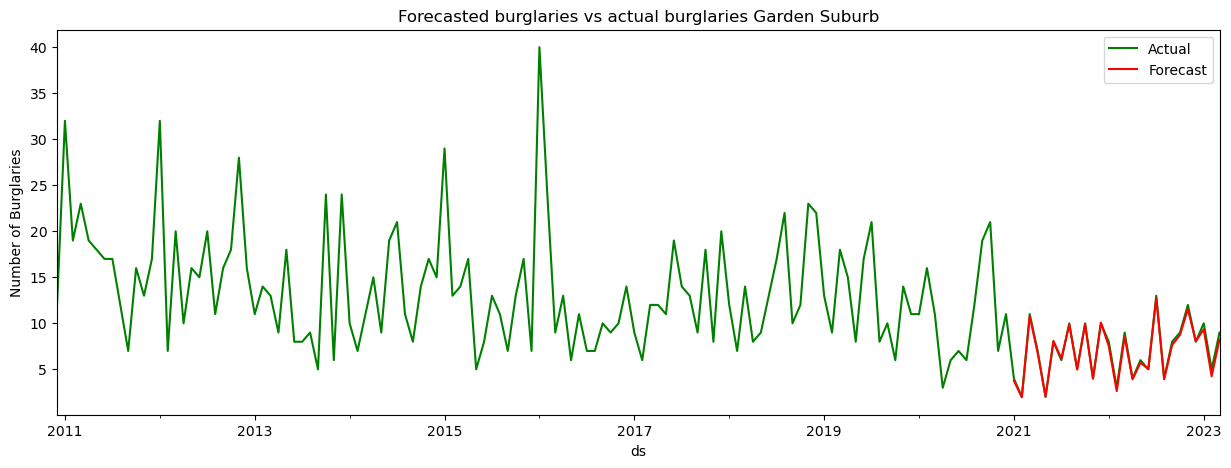

C:\Users\20203697\AppData\Local\Temp\ipykernel_14740\937257679.py:36: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:55:52 - cmdstanpy - INFO - Chain [1] start processing


          Date         ds  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  13                                0      0
1   2011-01-01 2011-01-01  2011  22                               22      0
2   2011-02-01 2011-02-01  2011  18                               18      0
3   2011-03-01 2011-03-01  2011  25                               25      0
4   2011-04-01 2011-04-01  2011  21                               21      0
..         ...        ...   ...  ..                              ...    ...
116 2020-08-01 2020-08-01  2020  18                               18      0
117 2020-09-01 2020-09-01  2020  13                               13      0
118 2020-10-01 2020-10-01  2020  19                               19      0
119 2020-11-01 2020-11-01  2020   9                                9      0
120 2020-12-01 2020-12-01  2020  11                               11      0

[121 rows x 6 columns]


17:55:53 - cmdstanpy - INFO - Chain [1] done processing


            ds       Date  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  13                                0      0
1   2011-01-01 2011-01-01  2011  22                               22      0
2   2011-02-01 2011-02-01  2011  18                               18      0
3   2011-03-01 2011-03-01  2011  25                               25      0
4   2011-04-01 2011-04-01  2011  21                               21      0
..         ...        ...   ...  ..                              ...    ...
143 2022-11-01 2022-11-01  2022   8                                8      0
144 2022-12-01 2022-12-01  2022   6                                6      0
145 2023-01-01 2023-01-01  2023  11                               11      0
146 2023-02-01 2023-02-01  2023   6                                6      0
147 2023-03-01 2023-03-01  2023  12                               12      0

[148 rows x 6 columns]
Golders Green


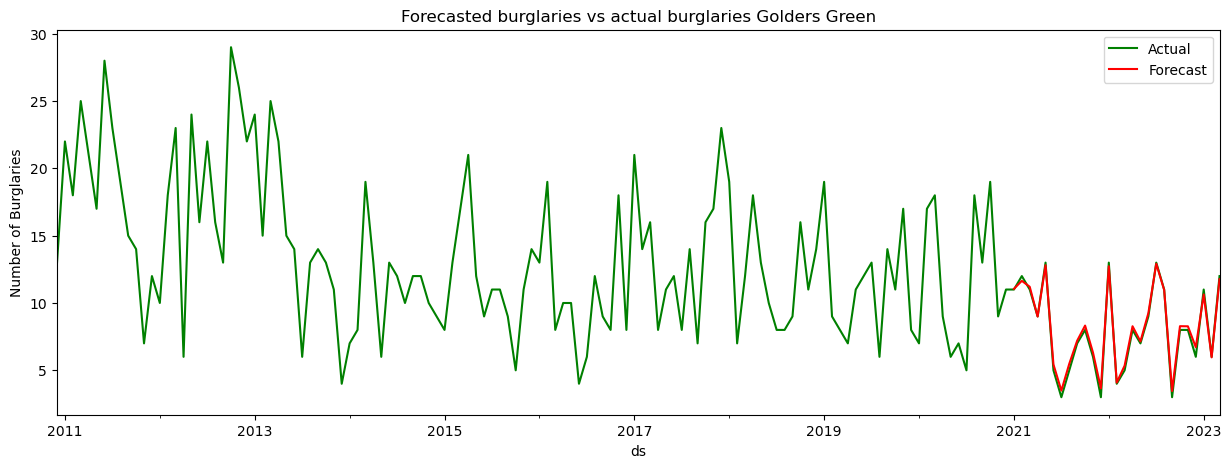

C:\Users\20203697\AppData\Local\Temp\ipykernel_14740\937257679.py:36: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:55:53 - cmdstanpy - INFO - Chain [1] start processing


          Date         ds  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  34                                0      0
1   2011-01-01 2011-01-01  2011  30                               30      0
2   2011-02-01 2011-02-01  2011  27                               27      0
3   2011-03-01 2011-03-01  2011  41                               41      0
4   2011-04-01 2011-04-01  2011  33                               33      0
..         ...        ...   ...  ..                              ...    ...
116 2020-08-01 2020-08-01  2020  19                               19      0
117 2020-09-01 2020-09-01  2020  20                               20      0
118 2020-10-01 2020-10-01  2020  14                               14      0
119 2020-11-01 2020-11-01  2020  21                               21      0
120 2020-12-01 2020-12-01  2020  19                               19      0

[121 rows x 6 columns]


17:55:53 - cmdstanpy - INFO - Chain [1] done processing


            ds       Date  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  34                                0      0
1   2011-01-01 2011-01-01  2011  30                               30      0
2   2011-02-01 2011-02-01  2011  27                               27      0
3   2011-03-01 2011-03-01  2011  41                               41      0
4   2011-04-01 2011-04-01  2011  33                               33      0
..         ...        ...   ...  ..                              ...    ...
143 2022-11-01 2022-11-01  2022  18                               18      0
144 2022-12-01 2022-12-01  2022  12                               12      0
145 2023-01-01 2023-01-01  2023  15                               15      0
146 2023-02-01 2023-02-01  2023  12                               12      0
147 2023-03-01 2023-03-01  2023  14                               14      0

[148 rows x 6 columns]
Hendon


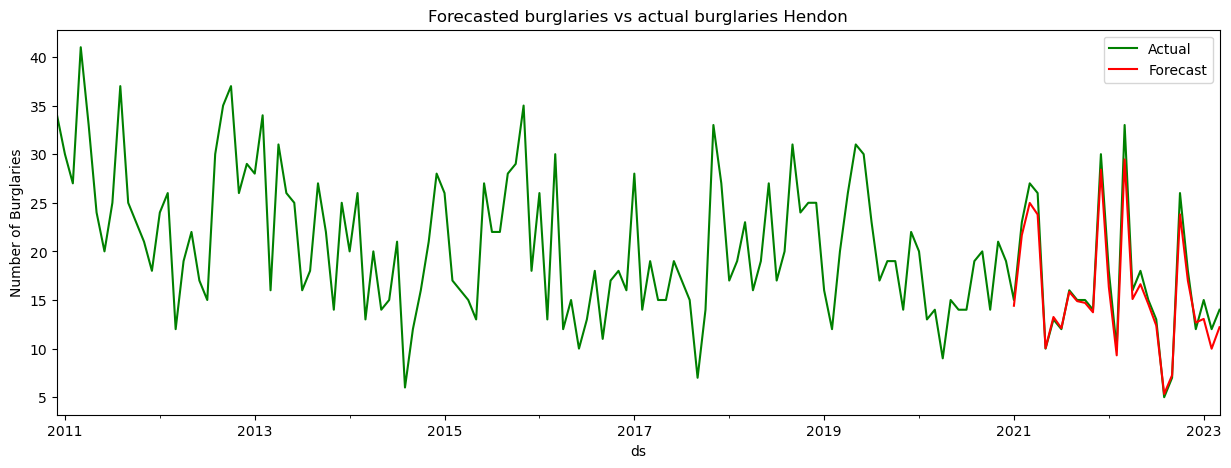

          Date         ds  year     y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  15.0                              0.0    0.0
1   2011-01-01 2011-01-01  2011  21.0                             21.0    0.0
2   2011-02-01 2011-02-01  2011  13.0                             13.0    0.0
3   2011-03-01 2011-03-01  2011  17.0                             17.0    0.0
4   2011-04-01 2011-04-01  2011  20.0                             20.0    0.0
..         ...        ...   ...   ...                              ...    ...
116 2020-08-01 2020-08-01  2020  11.0                             11.0    0.0
117 2020-09-01 2020-09-01  2020  12.0                             12.0    0.0
118 2020-10-01 2020-10-01  2020   8.0                              8.0    0.0
119 2020-11-01 2020-11-01  2020  12.0                             12.0    0.0
120 2020-12-01 2020-12-01  2020   7.0                              7.0    0.0

[121 rows x 6 columns]


C:\Users\20203697\AppData\Local\Temp\ipykernel_14740\937257679.py:36: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:55:54 - cmdstanpy - INFO - Chain [1] start processing
17:55:54 - cmdstanpy - INFO - Chain [1] done processing


            ds       Date  year     y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  15.0                         0.000000    0.0
1   2011-01-01 2011-01-01  2011  21.0                        21.000000    0.0
2   2011-02-01 2011-02-01  2011  13.0                        13.000000    0.0
3   2011-03-01 2011-03-01  2011  17.0                        17.000000    0.0
4   2011-04-01 2011-04-01  2011  20.0                        20.000000    0.0
..         ...        ...   ...   ...                              ...    ...
143 2022-11-01 2022-11-01  2022  11.0                        11.000000    0.0
144 2022-12-01 2022-12-01  2022   0.0                         9.489796    0.0
145 2023-01-01 2023-01-01  2023   9.0                         9.000000    0.0
146 2023-02-01 2023-02-01  2023   6.0                         6.000000    0.0
147 2023-03-01 2023-03-01  2023   7.0                         7.000000    0.0

[148 rows x 6 columns]
High Barnet


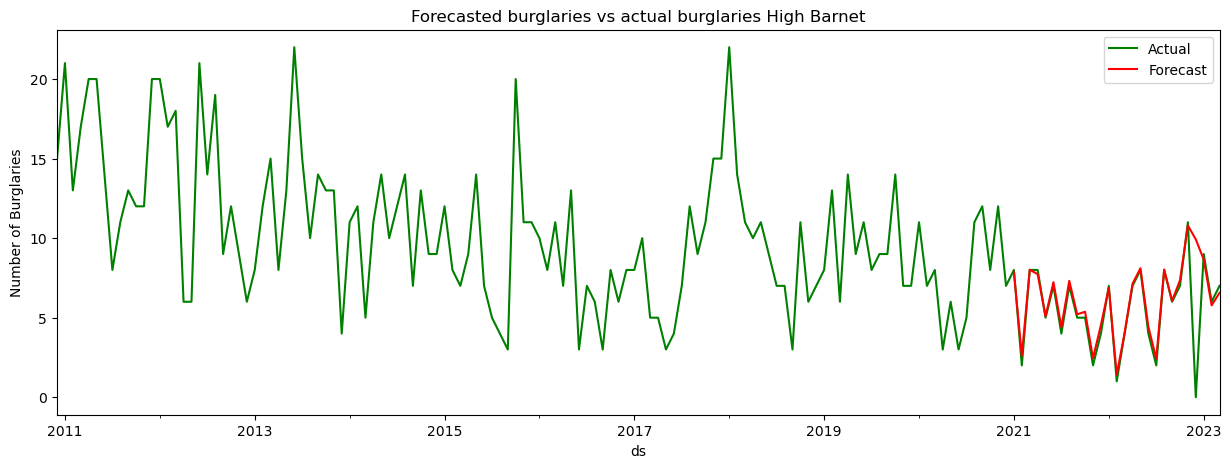

C:\Users\20203697\AppData\Local\Temp\ipykernel_14740\937257679.py:36: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:55:54 - cmdstanpy - INFO - Chain [1] start processing


          Date         ds  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  29                                0      0
1   2011-01-01 2011-01-01  2011  32                               32      0
2   2011-02-01 2011-02-01  2011  19                               19      0
3   2011-03-01 2011-03-01  2011  25                               25      0
4   2011-04-01 2011-04-01  2011  15                               15      0
..         ...        ...   ...  ..                              ...    ...
116 2020-08-01 2020-08-01  2020  15                               15      0
117 2020-09-01 2020-09-01  2020   9                                9      0
118 2020-10-01 2020-10-01  2020  14                               14      0
119 2020-11-01 2020-11-01  2020  15                               15      0
120 2020-12-01 2020-12-01  2020   9                                9      0

[121 rows x 6 columns]


17:55:55 - cmdstanpy - INFO - Chain [1] done processing


            ds       Date  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  29                                0      0
1   2011-01-01 2011-01-01  2011  32                               32      0
2   2011-02-01 2011-02-01  2011  19                               19      0
3   2011-03-01 2011-03-01  2011  25                               25      0
4   2011-04-01 2011-04-01  2011  15                               15      0
..         ...        ...   ...  ..                              ...    ...
143 2022-11-01 2022-11-01  2022   8                                8      0
144 2022-12-01 2022-12-01  2022  19                               19      0
145 2023-01-01 2023-01-01  2023  16                               16      0
146 2023-02-01 2023-02-01  2023  17                               17      0
147 2023-03-01 2023-03-01  2023   7                                7      0

[148 rows x 6 columns]
Mill Hill


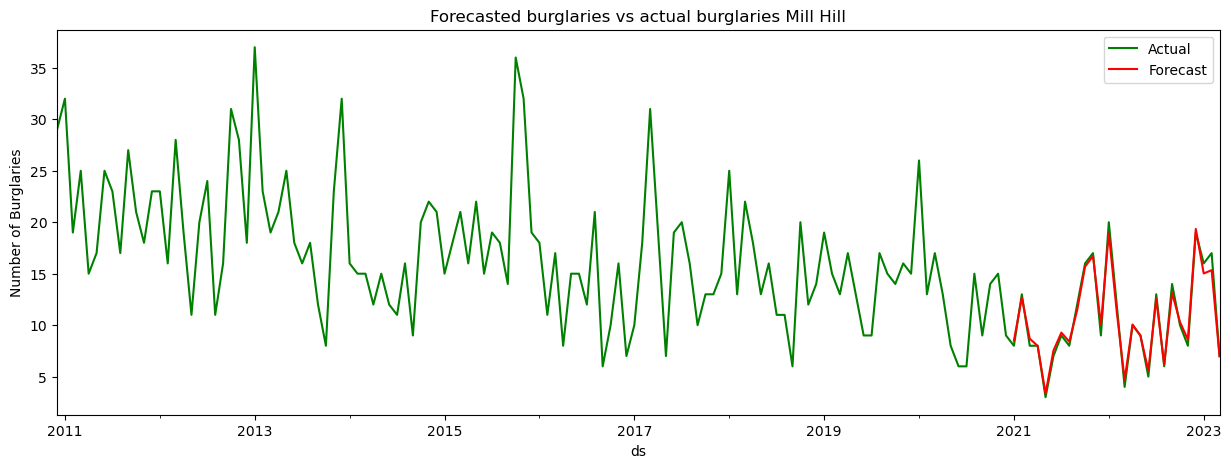

C:\Users\20203697\AppData\Local\Temp\ipykernel_14740\937257679.py:36: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:55:55 - cmdstanpy - INFO - Chain [1] start processing


          Date         ds  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010   7                                0      0
1   2011-01-01 2011-01-01  2011  16                               16      0
2   2011-02-01 2011-02-01  2011   5                                5      0
3   2011-03-01 2011-03-01  2011  22                               22      0
4   2011-04-01 2011-04-01  2011  16                               16      0
..         ...        ...   ...  ..                              ...    ...
116 2020-08-01 2020-08-01  2020   6                                6      0
117 2020-09-01 2020-09-01  2020   3                                3      0
118 2020-10-01 2020-10-01  2020   8                                8      0
119 2020-11-01 2020-11-01  2020  11                               11      0
120 2020-12-01 2020-12-01  2020   7                                7      0

[121 rows x 6 columns]


17:55:55 - cmdstanpy - INFO - Chain [1] done processing


            ds       Date  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010   7                                0      0
1   2011-01-01 2011-01-01  2011  16                               16      0
2   2011-02-01 2011-02-01  2011   5                                5      0
3   2011-03-01 2011-03-01  2011  22                               22      0
4   2011-04-01 2011-04-01  2011  16                               16      0
..         ...        ...   ...  ..                              ...    ...
143 2022-11-01 2022-11-01  2022   5                                5      0
144 2022-12-01 2022-12-01  2022   5                                5      0
145 2023-01-01 2023-01-01  2023   6                                6      0
146 2023-02-01 2023-02-01  2023   3                                3      0
147 2023-03-01 2023-03-01  2023   2                                2      0

[148 rows x 6 columns]
Underhill


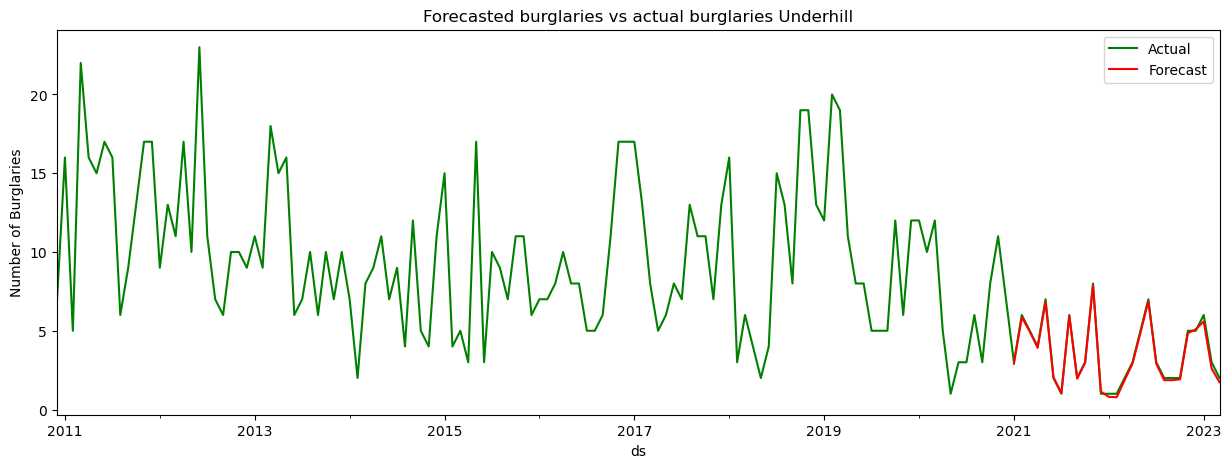

C:\Users\20203697\AppData\Local\Temp\ipykernel_14740\937257679.py:36: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:55:56 - cmdstanpy - INFO - Chain [1] start processing


          Date         ds  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  27                                0      0
1   2011-01-01 2011-01-01  2011  28                               28      0
2   2011-02-01 2011-02-01  2011  20                               20      0
3   2011-03-01 2011-03-01  2011  21                               21      0
4   2011-04-01 2011-04-01  2011  23                               23      0
..         ...        ...   ...  ..                              ...    ...
116 2020-08-01 2020-08-01  2020   7                                7      0
117 2020-09-01 2020-09-01  2020  13                               13      0
118 2020-10-01 2020-10-01  2020  11                               11      0
119 2020-11-01 2020-11-01  2020  17                               17      0
120 2020-12-01 2020-12-01  2020  13                               13      0

[121 rows x 6 columns]


17:55:56 - cmdstanpy - INFO - Chain [1] done processing


            ds       Date  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  27                                0      0
1   2011-01-01 2011-01-01  2011  28                               28      0
2   2011-02-01 2011-02-01  2011  20                               20      0
3   2011-03-01 2011-03-01  2011  21                               21      0
4   2011-04-01 2011-04-01  2011  23                               23      0
..         ...        ...   ...  ..                              ...    ...
143 2022-11-01 2022-11-01  2022  13                               13      0
144 2022-12-01 2022-12-01  2022   9                                9      0
145 2023-01-01 2023-01-01  2023  17                               17      0
146 2023-02-01 2023-02-01  2023   5                                5      0
147 2023-03-01 2023-03-01  2023  13                               13      0

[148 rows x 6 columns]
West Finchley


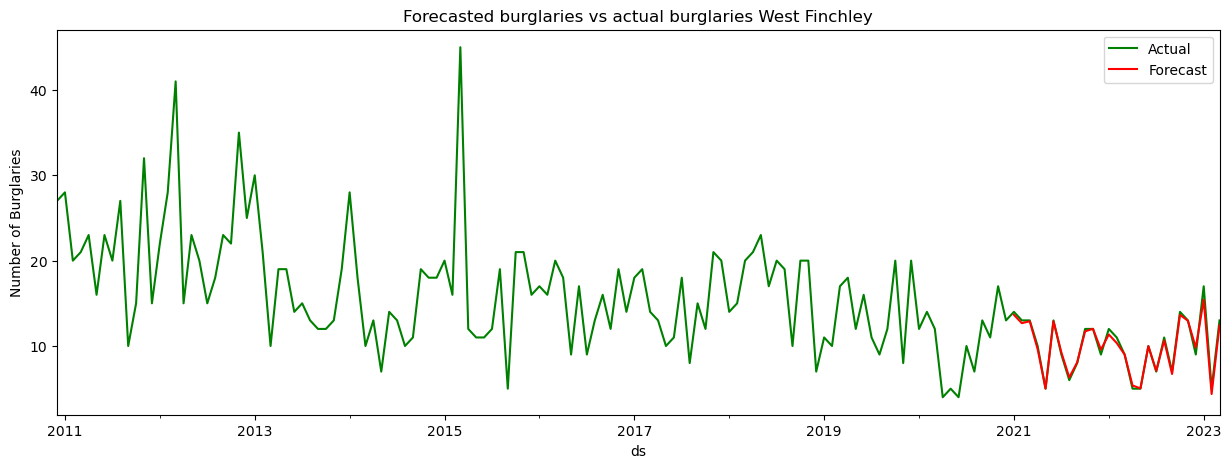

          Date         ds  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  15                                0      0
1   2011-01-01 2011-01-01  2011  17                               17      0
2   2011-02-01 2011-02-01  2011  18                               18      0
3   2011-03-01 2011-03-01  2011  10                               10      0
4   2011-04-01 2011-04-01  2011  15                               15      0
..         ...        ...   ...  ..                              ...    ...
116 2020-08-01 2020-08-01  2020  11                               11      0
117 2020-09-01 2020-09-01  2020  10                               10      0
118 2020-10-01 2020-10-01  2020  10                               10      0
119 2020-11-01 2020-11-01  2020   6                                6      0
120 2020-12-01 2020-12-01  2020  10                               10      0

[121 rows x 6 columns]


C:\Users\20203697\AppData\Local\Temp\ipykernel_14740\937257679.py:36: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:55:56 - cmdstanpy - INFO - Chain [1] start processing
17:55:56 - cmdstanpy - INFO - Chain [1] done processing


            ds       Date  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  15                                0      0
1   2011-01-01 2011-01-01  2011  17                               17      0
2   2011-02-01 2011-02-01  2011  18                               18      0
3   2011-03-01 2011-03-01  2011  10                               10      0
4   2011-04-01 2011-04-01  2011  15                               15      0
..         ...        ...   ...  ..                              ...    ...
143 2022-11-01 2022-11-01  2022  10                               10      0
144 2022-12-01 2022-12-01  2022   9                                9      0
145 2023-01-01 2023-01-01  2023  11                               11      0
146 2023-02-01 2023-02-01  2023   9                                9      0
147 2023-03-01 2023-03-01  2023   8                                8      0

[148 rows x 6 columns]
West Hendon


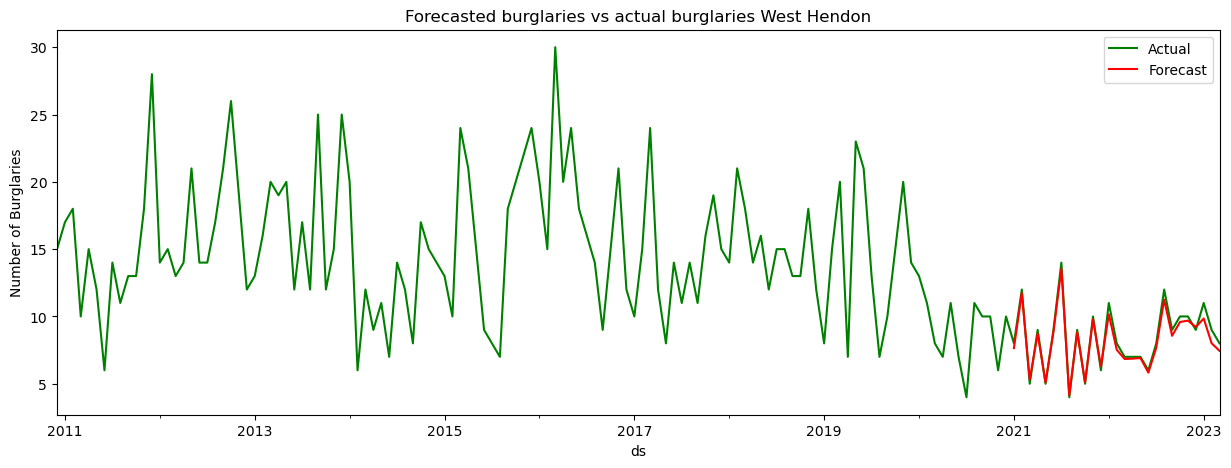

C:\Users\20203697\AppData\Local\Temp\ipykernel_14740\937257679.py:36: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

17:55:57 - cmdstanpy - INFO - Chain [1] start processing


          Date         ds  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  11                                0      0
1   2011-01-01 2011-01-01  2011  22                               22      0
2   2011-02-01 2011-02-01  2011  18                               18      0
3   2011-03-01 2011-03-01  2011   5                                5      0
4   2011-04-01 2011-04-01  2011  12                               12      0
..         ...        ...   ...  ..                              ...    ...
116 2020-08-01 2020-08-01  2020   1                                1      0
117 2020-09-01 2020-09-01  2020  15                               15      0
118 2020-10-01 2020-10-01  2020  10                               10      0
119 2020-11-01 2020-11-01  2020  19                               19      0
120 2020-12-01 2020-12-01  2020   4                                4      0

[121 rows x 6 columns]


17:55:57 - cmdstanpy - INFO - Chain [1] done processing


            ds       Date  year   y  Population per square kilometre  covid
0   2010-12-01 2010-12-01  2010  11                                0      0
1   2011-01-01 2011-01-01  2011  22                               22      0
2   2011-02-01 2011-02-01  2011  18                               18      0
3   2011-03-01 2011-03-01  2011   5                                5      0
4   2011-04-01 2011-04-01  2011  12                               12      0
..         ...        ...   ...  ..                              ...    ...
143 2022-11-01 2022-11-01  2022  15                               15      0
144 2022-12-01 2022-12-01  2022   7                                7      0
145 2023-01-01 2023-01-01  2023   5                                5      0
146 2023-02-01 2023-02-01  2023   6                                6      0
147 2023-03-01 2023-03-01  2023   8                                8      0

[148 rows x 6 columns]
Woodhouse


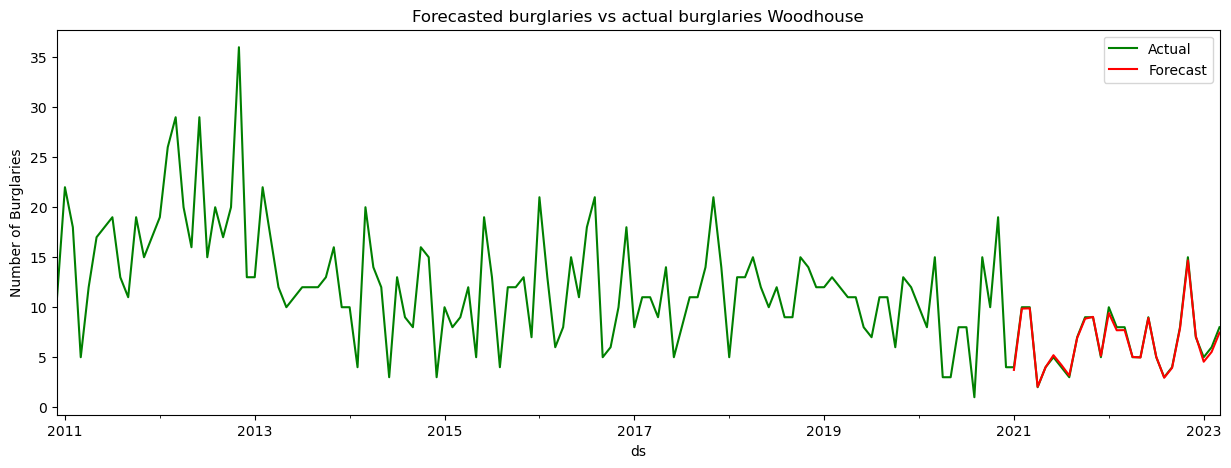

0.4017210212783184


In [37]:
# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='3/1/2023', freq='MS').to_frame()

# Specify columns: ds, y, Date
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
dates['Date'] = dates[0]
dates = dates[['Date']]

# Loop over wards
wards = ['Brunswick Park', 'Burnt Oak', 'Childs Hill', 'East Barnet',
       'East Finchley', 'Edgware', 'Finchley Church End', 'Garden Suburb',
       'Golders Green', 'Hendon', 'High Barnet', 'Mill Hill', 'Underhill',
       'West Finchley', 'West Hendon', 'Woodhouse']
mse = []
mae = []

for ward in wards: 
       # Select data of ward
       df_ward = df_per_ward[df_per_ward['Ward']==ward]
       df_ward = df_ward[['ds', 'Date', 'year', 'y', 'Population per square kilometre','covid']]
       # Merge with all dates to have a consistent dataframe
       df_ward = pd.merge(dates, df_ward, how="left", on='Date')
       df_ward['ds'] = df_ward['Date']
       df_ward['y'] = df_ward['y'].fillna(0)
       df_ward = df_ward.fillna(df_ward.mean())
       df_ward['year'] = pd.DatetimeIndex(df_ward['Date']).year
       train_ward = df_ward[df_ward['year']<(training_upto+1)]
       test_ward = df_ward[(df_ward['year']>training_upto)] 
       best_model = Prophet(seasonality_mode= 'additive', changepoint_prior_scale= 15, seasonality_prior_scale= 15, holidays_prior_scale= 30, holidays= holiday)
       best_model.add_regressor('Population per square kilometre')
       best_model.fit(train_ward)
       future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
       future_dates = pd.merge(future_dates, df_ward, how="left", on='ds')
       forecast = best_model.predict(future_dates[-forecast_upto:])
       mae.append(mean_absolute_error(test_ward['y'], forecast['yhat']))
       mse.append(mean_squared_error(test_ward['y'], forecast['yhat']))
       f, ax = plt.subplots(figsize=(14,5))
       f.set_figheight(5)
       ax.set_xlabel("Year")
       ax.set_ylabel("Number of Burglaries")
       f.set_figwidth(15)
       
       df_ward.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
       forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
       title = 'Forecasted burglaries vs actual burglaries ' + ward
       plt.title(title)
       plt.show()

print("Mean MAE", np.mean(mae))
       